--- GC=F データ取得中 ---


/usr/local/python/3.12.1/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


現在価格: 5081.30
昨日の高値: 5107.89990234375 / 安値: 5010.89990234375
直近サポート(オレンジ): 5075.12
抽出された全ライン: [np.float64(4700.60009765625), np.float64(4707.60009765625), np.float64(4720.0450439453125), np.float64(4734.246940768495), np.float64(4763.394337780071), np.float64(4795.922648879717), np.float64(4846.778275199558), np.float64(4887.800048828125), np.float64(4908.123009314904), np.float64(4941.777422505041), np.float64(4971.16005859375), np.float64(4982.155239762931), np.float64(5002.133463541667), np.float64(5011.683268229167), np.float64(5034.800037202381), np.float64(5075.122934857537)]
直近レジ: []
直近サポ: [np.float64(5075.122934857537), np.float64(5034.800037202381), np.float64(5011.683268229167), np.float64(5002.133463541667), np.float64(4982.155239762931), np.float64(4971.16005859375), np.float64(4941.777422505041), np.float64(4908.123009314904), np.float64(4887.800048828125), np.float64(4846.778275199558), np.float64(4795.922648879717), np.float64(4763.394337780071), np.float64(4734.24694076

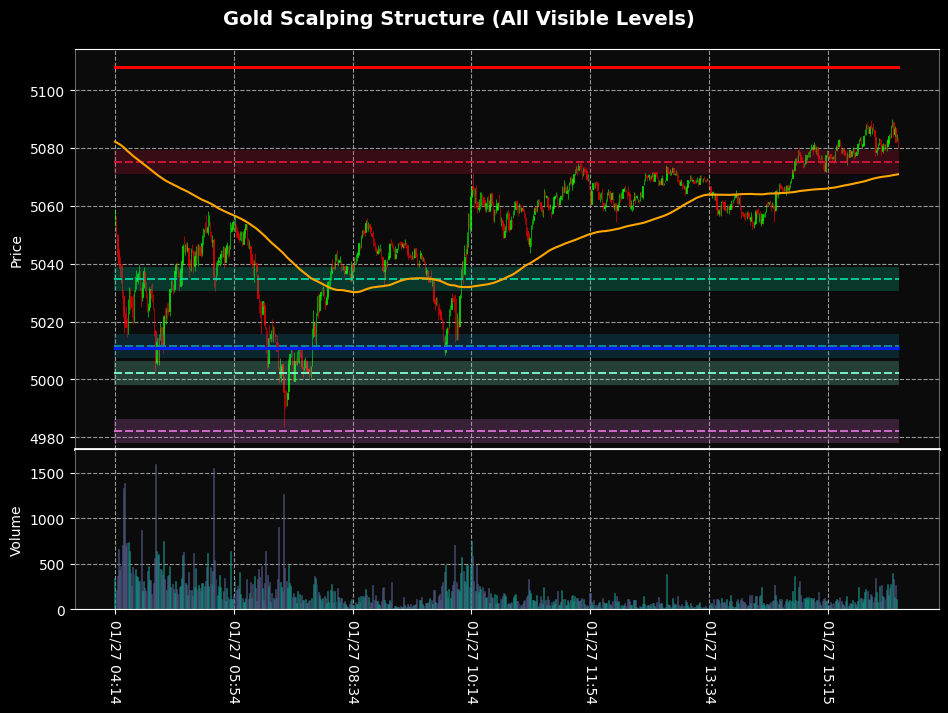

In [51]:
import yfinance as yf
import pandas as pd
import mplfinance as mpf
import numpy as np
from datetime import timedelta
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

class GoldChartGenerator:
    def __init__(self, symbol="GC=F"):
        self.symbol = symbol
        self.df = None
    
    def fetch_data(self, period="5d", interval="5m"):
        print(f"--- {self.symbol} データ取得中 ---")
        try:
            df = yf.download(self.symbol, interval=interval, period=period, progress=False)
            if df.empty: return None
            if isinstance(df.columns, pd.MultiIndex): df.columns = df.columns.get_level_values(0)
            for col in ["Open", "High", "Low", "Close", "Volume"]:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            df.dropna(inplace=True)
            if df.index.tz is None: df.index = df.index.tz_localize('UTC')
            df.index = df.index.tz_convert('Asia/Tokyo')
            df.index.name = "Datetime"
            df['MA200'] = df['Close'].rolling(window=200).mean()
            self.df = df
            return df
        except Exception: return None

    def _get_yesterday_levels(self):
        """昨日の高安"""
        if self.df is None: return None, None
        last_date = self.df.index[-1].date()
        prev_data = self.df[self.df.index.date < last_date]
        if prev_data.empty: return None, None
        target_date = prev_data.index[-1].date()
        target = prev_data[prev_data.index.date == target_date]
        return target['High'].max(), target['Low'].min()

    def _get_strong_levels(self, df, merge_dist=3.0, min_touches=2):
        """
        強いラインの抽出
        merge_dist: 3.0ドル以内の誤差は同じ帯とみなす（少し広げてバーコード化を防ぐ）
        min_touches: 2回以上意識されたら採用（これで急落時の戻り目なども拾う）
        """
        candidates = []
        # 高値・安値の両方を候補にする
        for col, comp in [('High', np.greater), ('Low', np.less)]:
            vals = df[col].values
            idxs = argrelextrema(vals, comparator=comp, order=5)[0]
            for idx in idxs:
                candidates.append(df.iloc[idx][col])

        
        candidates.sort()
        if not candidates: return []

        # 近い価格をまとめる（クラスタリング）
        clusters = []
        if candidates:
            current_cluster = [candidates[0]]
            for i in range(1, len(candidates)):
                if candidates[i] - current_cluster[-1] < merge_dist:
                    current_cluster.append(candidates[i])
                else:
                    clusters.append(current_cluster)
                    current_cluster = [candidates[i]]
            clusters.append(current_cluster)

        # 厳選（min_touches回以上反発した場所の中心のみ返す）
        strong_levels = []
        for cluster in clusters:
            if len(cluster) >= min_touches:
                strong_levels.append(np.mean(cluster))
        
        return strong_levels

    def generate_chart(self, display_hours=12, save_path=None):
        if self.df is None:
            print("データがありません")
            return
        
        # 表示範囲のデータ
        plot_start = self.df.index[-1] - timedelta(hours=display_hours)
        df_plot = self.df[self.df.index >= plot_start].copy()
        current_price = self.df['Close'].iloc[-1]
        
        # 画面のY軸範囲（これに入ってる線だけ描画するため）
        view_max = df_plot['High'].max()
        view_min = df_plot['Low'].min()
        margin = (view_max - view_min) * 0.1 # 上下少し余裕を持たせる
        
        # 昨日の高安
        y_high, y_low = self._get_yesterday_levels()
        
        # サポレジ取得（全期間から計算）
        levels = self._get_strong_levels(self.df, merge_dist=3.0, min_touches=2)
        
        # 現在価格上下で分類
        res_levels = [x for x in levels if x > current_price]
        sup_levels = [x for x in levels if x < current_price]
        
        res_levels.sort() # 近い順（昇順）
        sup_levels.sort(reverse=True) # 近い順（降順）
        
        # --- 描画用リスト作成 ---
        h_lines = []
        h_colors = []
        h_styles = []
        h_widths = []
        h_alphas = []

        LEVEL_COLORS = [
            '#ffb000',  # オレンジ
            '#00bfff',  # 青
            '#4cff4c',  # 緑
            '#c77dff',  # 紫
            '#ffd166',  # 黄
            '#06d6a0',  # エメラルド
            '#118ab2',  # 深い青
            '#7fffd4',  # アクア
            '#da70d6',  # 薄紫
            '#90ee90',  # ライトグリーン
            '#87cefa',  # ライトブルー
            '#ffa07a',  # サーモン
            '#20b2aa',  # ダークターコイズ
            '#a8dadc',  # ペールシアン
            '#e9c46a'   # ライトイエロー
        ]


        # 1. 昨日の高安（最強）: 赤・青の実線
        if y_high:
            h_lines.append(y_high); h_colors.append('red'); h_styles.append('-'); h_widths.append(2.0); h_alphas.append(1.0)
        if y_low:
            h_lines.append(y_low); h_colors.append('blue'); h_styles.append('-'); h_widths.append(2.0); h_alphas.append(1.0)

        # 2. レジスタンス（上）
        # ★制限を撤廃してループですべて処理
        for i, level in enumerate(res_levels):
            if level > view_max + margin:
                continue

            if i == 0:
                color = '#dc143c'   # 直近レジ（クリムゾン固定）
            else:
                color = LEVEL_COLORS[(i - 1) % len(LEVEL_COLORS)]

            # 帯（背景）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('-')
            h_widths.append(16.0)
            h_alphas.append(0.22)

            # 中心線
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('--')
            h_widths.append(1.5)
            h_alphas.append(0.9)

        # 3. サポート（下）
        # ★制限を撤廃してループですべて処理
        for i, level in enumerate(sup_levels):
            if level < view_min - margin:
                continue

            if i == 0:
                color = '#dc143c'   # 直近サポ（クリムゾン固定）
            else:
                color = LEVEL_COLORS[(i + 4) % len(LEVEL_COLORS)]  # 被り防止

            # 帯（背景）
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('-')
            h_widths.append(16.0)
            h_alphas.append(0.22)

            # 中心線
            h_lines.append(level)
            h_colors.append(color)
            h_styles.append('--')
            h_widths.append(1.5)
            h_alphas.append(0.9)


        # --- プロット ---
        ap = [mpf.make_addplot(self.df.loc[df_plot.index, 'MA200'], color='orange', width=1.5)]

        # --- 色 ---
        mc = mpf.make_marketcolors(
            up='lime',
            down='red',
            edge='inherit',
            wick='inherit',
            volume='inherit'
        )

        style = mpf.make_mpf_style(
            base_mpf_style='nightclouds',
            marketcolors=mc
        )
        
        plot_args = {
            "type": "candle",
            "style": style,
            "volume": True,
            "volume_alpha": 0.5,
            "addplot": ap,
            "datetime_format": "%m/%d %H:%M",
            "xrotation": -90,
            "figsize": (12, 8),
            "hlines": dict(
                hlines=h_lines,
                colors=h_colors,
                linestyle=h_styles,
                linewidths=h_widths,
                alpha=h_alphas
            )
        }

        if save_path:
            plot_args["savefig"] = save_path

        fig, axes = mpf.plot(df_plot, **plot_args, returnfig=True)

        fig.suptitle(
            "Gold Scalping Structure (All Visible Levels)",
            fontsize=14,
            color='white',
            y=0.93   # ← 上に逃がす
        )

        # price と volume の境界（price 側の下）
        axes[0].spines['bottom'].set_linewidth(2.0)
        axes[0].spines['bottom'].set_color('white')

        # volume 側の上
        axes[1].spines['top'].set_linewidth(2.0)
        axes[1].spines['top'].set_color('white')

        for ax in axes:
            ax.spines['left'].set_visible(True)
            ax.spines['right'].set_visible(True)
            ax.spines['left'].set_color('#666666')
            ax.spines['right'].set_color('#666666')
            ax.spines['left'].set_linewidth(0.8)
            ax.spines['right'].set_linewidth(0.8)

        print(f"現在価格: {current_price:.2f}")
        print(f"昨日の高値: {y_high} / 安値: {y_low}")
        if res_levels: print(f"直近レジスタンス(オレンジ): {res_levels[0]:.2f}")
        if sup_levels: print(f"直近サポート(オレンジ): {sup_levels[0]:.2f}")

        print("抽出された全ライン:", levels)
        print("直近レジ:", res_levels)
        print("直近サポ:", sup_levels)


if __name__ == "__main__":
    gen = GoldChartGenerator()
    df = gen.fetch_data(period="7d", interval="1m")
    gen.generate_chart(display_hours=12)

In [53]:
def simple_trend_predict(df):
    """
    過去データのdfより'Close'列を使って簡単な次の値動きを推測する

    Args:
        df (dateFrame): 過去データ
    Returns:
        str: "up", "down", "stable"
    """

    if df is None or df.empty:
        return None

    # 直近5本の終値の傾きで推測
    recent_closes = df['Close'].iloc[-5:]

    # 単純傾き
    slope = recent_closes.pct_change().mean() # 平均変化率

    # 移動平均との比較
    ma5 = recent_closes.mean()
    ma20 = df['Close'].iloc[-20:].mean() if len(df) >= 20 else ma5

    # 推測ロジック
    if slope > 0.0005 and ma5 > ma20:
        return "UP"
    elif slope < -0.0005 and ma5 < ma20:
        return "DOWN"
    else:
        return "STABLE"

prediction = simple_trend_predict(df)
print("次の値動き予測:", prediction)

次の値動き予測: STABLE
